Run on MacBook

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

from scipy.optimize import root_scalar

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
band = 'g'
field = 'south'
region_name = 'decals_ngc'

In [4]:
if (field=='north') and ((band=='g') or (band=='r')):
    pixscale_native = 0.454
else:
    pixscale_native = 0.262
# pixscale = 0.262 # pixscale for cutout queries

# location on NERSC: /global/u2/r/rongpu/share/psf_profile/data/
tmp = np.loadtxt('../data/{}_poly_fit.txt'.format(region_name))
band_index = np.where(band==np.array(['g', 'r', 'z']))[0][0]
poly = np.poly1d(tmp[band_index])
print(poly)
profile_fit = np.poly1d(poly)

        5          4         3         2
-0.077 x - 0.2577 x + 1.984 x - 2.181 x - 3.396 x - 2.231


__Check that the fit matches the data__

In [5]:
# ls_mag_bins = [10.5, 11.75, 13.0, 14.25, 15.5]
# ls_mag_bright = 6.5

# rlimits = {}
# rlimits['g'] = 1, 8, 20, 200
# rlimits['r'] = 1, 7, 20, 200
# rlimits['z'] = 1, 7, 20, 200

# r1, r2, r3, rmax = rlimits[band]

# # location on NERSC: /global/u2/r/rongpu/share/psf_profile/data/
# profile = Table.read('../data/average_profiles_{}_{}_{}.txt'.format(field, region_name, band), format='ascii.commented_header')
# indiv = Table.read('../data/individual_profiles_{}_{}_{}.fits'.format(field, region_name, band))

# profile_bright = Table.read('../data/average_profiles_{}_{}_{}-bright.txt'.format(field, region_name, band), format='ascii.commented_header')
# indiv_bright = Table.read('../data/individual_profiles_{}_{}_{}-bright.fits'.format(field, region_name, band))

# index = -1
# # normalize to the flux of a 22.5 mag star per pixel
# norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
# x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
# y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
# mask = (x>r1) & (x<r2)
# xdata = x[mask]
# ydata = y[mask]

# index = 0
# # normalize to the flux of a 22.5 mag star per pixel
# norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
# x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
# y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
# mask = (x>=r2) & (x<r3)
# xdata = np.concatenate((xdata, x[mask]))
# ydata = np.concatenate((ydata, y[mask]))

# # normalize to the flux of a 22.5 mag star per pixel
# norm = 10**((ls_mag_bright-22.5)/2.5) * pixscale_native**2
# x = profile_bright['radius_{}_{:.2f}'.format(band, ls_mag_bright)]
# y = norm * profile_bright['flux_{}_{:.2f}'.format(band, ls_mag_bright)]
# mask = (x>=r3) & (x<rmax)
# xdata = np.concatenate((xdata, x[mask]))
# ydata = np.concatenate((ydata, y[mask]))

# mask1 = (xdata>r1) & (xdata<r2)
# mask2 = (xdata>=r2) & (xdata<r3)
# mask3 = (xdata>=r3) & (xdata<rmax)

# xfit = np.logspace(-1, 3, 2000)
# yfit = 10**(profile_fit(np.log10(xfit)))

# plt.figure(figsize=(11, 8))
# plt.loglog(xfit, yfit, '-', lw=1.2, alpha=1., 
#            label='fit')
# plt.loglog(xdata[mask1], ydata[mask1], '.', lw=1.2, alpha=1., ms=4.,
#            label='data ({}mag = {:.2f})'.format(band, ls_mag_bins[-1]))
# plt.loglog(xdata[mask2], ydata[mask2], '.', lw=1.2, alpha=1., ms=4.,
#            label='data ({}mag = {:.2f})'.format(band, ls_mag_bins[0]))
# plt.loglog(xdata[mask3], ydata[mask3], '.', lw=1.2, alpha=1., ms=4.,
#            label='data ({}mag = {:.2f})'.format(band, ls_mag_bright))
# plt.title('{} {} {}-band'.format(field, region_name, band))
# plt.axis([0.5, 300, 5e-11, 1e-2])
# plt.grid(alpha=0.5)
# plt.xlabel('Radius (arcsec)')
# plt.ylabel('SB (nmgy/pixel)')
# plt.legend()
# plt.show()

__Normalize to surface brightness per arsec__

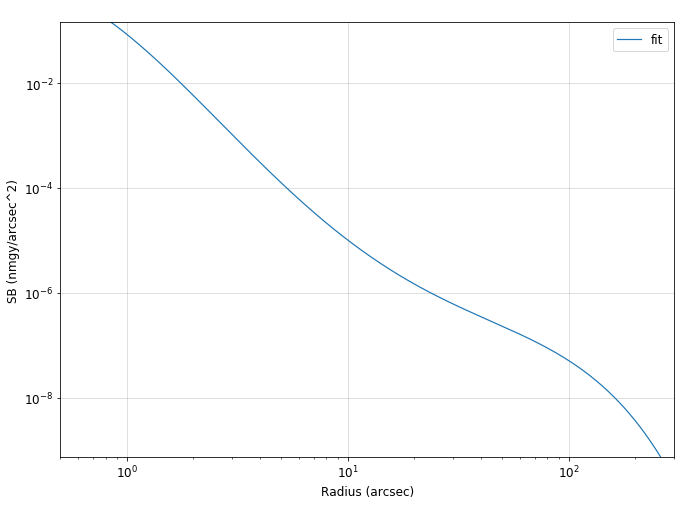

In [7]:
profile_fit_norm = lambda r: 10**(profile_fit(np.log10(r)))/(pixscale_native**2)

xfit = np.logspace(-1, 3, 2000)

plt.figure(figsize=(11, 8))
plt.loglog(xfit, profile_fit_norm(xfit), '-', lw=1.2, alpha=1., 
           label='fit')
plt.axis([0.5, 300, 5e-11/(pixscale_native**2), 1e-2/(pixscale_native**2)])
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('SB (nmgy/arcsec^2)')
plt.title(' ')
plt.legend()
plt.show()

In [8]:
sb_limit_in_mag = 31

sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)
print('SB = {}'.format(sb_limit_in_nmgy))

mag_list = np.linspace(6, 23, 200)
radius_lim_list = np.zeros(len(mag_list))
for index, mag in enumerate(mag_list):
    f = lambda r: 10**((22.5-mag)/2.5) * profile_fit_norm(r) - sb_limit_in_nmgy
    try:
        radius_lim_list[index] = root_scalar(f, bracket=[2, 200]).root
    except ValueError:
        if mag<16:
            radius_lim_list[index] = np.nan
        else:
            radius_lim_list[index] = 0

SB = 0.00039810717055349735


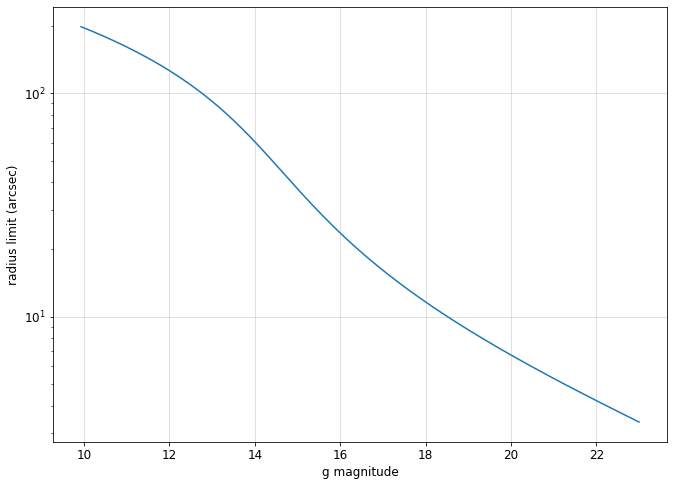

In [9]:
plt.figure(figsize=(11, 8))
plt.semilogy(mag_list, radius_lim_list, '-')
plt.grid(alpha=0.5)
plt.xlabel(band+' magnitude')
plt.ylabel('radius limit (arcsec)')
# plt.ylim(ymin=1.5)
# plt.legend()
plt.show()

----------
## All three bands

g-band
SB_mag = 28.5, SB = 0.003981071705534973


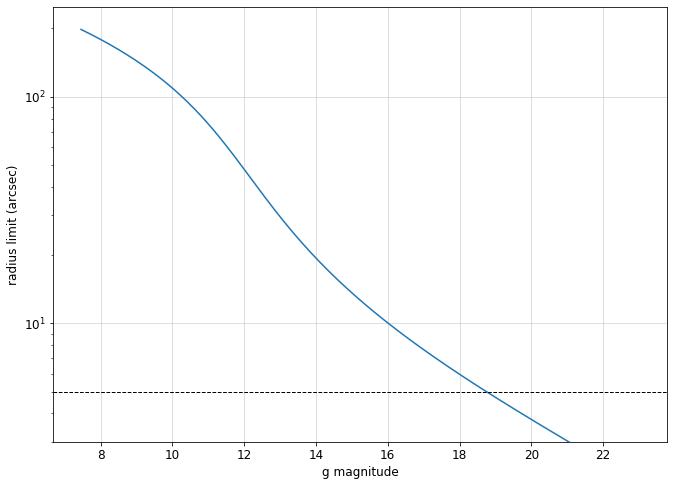

r-band
SB_mag = 28, SB = 0.00630957344480193


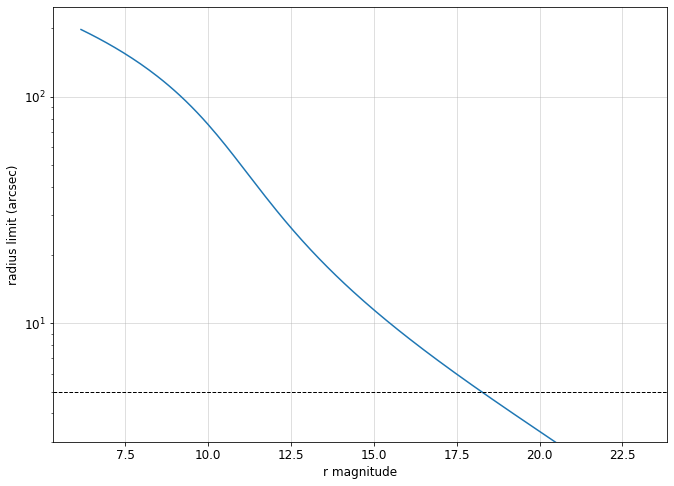

z-band
SB_mag = 27.5, SB = 0.01


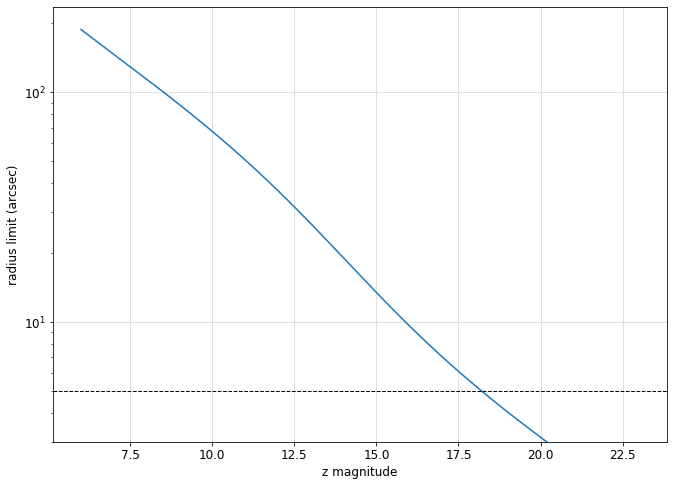

In [10]:
# sb_limit_in_mag_list1 = [31, 30.5, 30]
sb_limit_in_mag_list = [28.5, 28, 27.5]
# sb_limit_in_mag_list = [26, 25.5, 25]
bands = ['g', 'r', 'z']

for band, sb_limit_in_mag in zip(bands, sb_limit_in_mag_list):
    
    sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)
        
    print(band+'-band')
    print('SB_mag = {}, SB = {}'.format(sb_limit_in_mag, sb_limit_in_nmgy))
    
    field = 'south'
    region_name = 'decals_ngc'

    if (field=='north') and ((band=='g') or (band=='r')):
        pixscale_native = 0.454
    else:
        pixscale_native = 0.262
    # pixscale = 0.262 # pixscale for cutout queries

    tmp = np.loadtxt('../data/{}_poly_fit.txt'.format(region_name))
    band_index = np.where(band==np.array(['g', 'r', 'z']))[0][0]
    poly = np.poly1d(tmp[band_index])
    # print(poly)
    profile_fit = np.poly1d(poly)
    # normalize to surface brightness per arsec
    profile_fit_norm = lambda r: 10**(profile_fit(np.log10(r)))/(pixscale_native**2)
    
    mag_list = np.linspace(6, 23, 200)
    radius_lim_list = np.zeros(len(mag_list))
    for index, mag in enumerate(mag_list):
        f = lambda r: 10**((22.5-mag)/2.5) * profile_fit_norm(r) - sb_limit_in_nmgy
        try:
            radius_lim_list[index] = root_scalar(f, bracket=[2, 200]).root
        except ValueError:
            if mag<16:
                radius_lim_list[index] = np.nan
            else:
                radius_lim_list[index] = 0

    plt.figure(figsize=(11, 8))
    plt.semilogy(mag_list, radius_lim_list, '-')
    plt.grid(alpha=0.5)
    plt.xlabel(band+' magnitude')
    plt.ylabel('radius limit (arcsec)')
    plt.axhline(5., lw=1, ls='--', color='k')
    plt.ylim(ymin=3.)
    # plt.axis([8, 23, 3, 240])
    plt.show()

__Compare different SB limits__

g-band


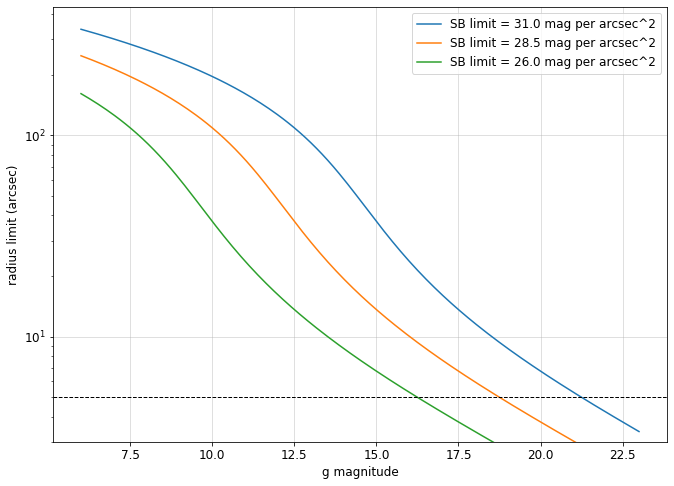

r-band


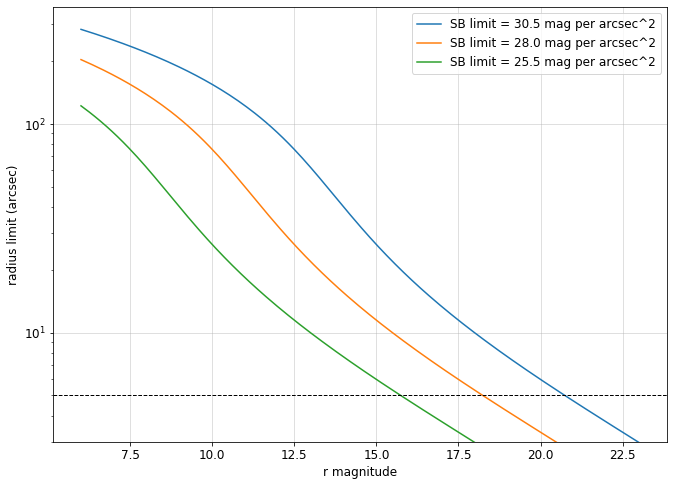

z-band


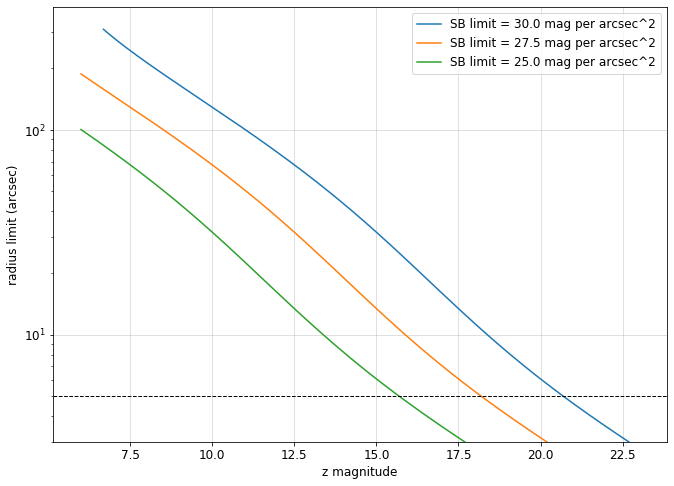

In [11]:
sb_limit_in_mag_list_all = {'g':[31, 28.5, 26.],
                            'r':[30.5, 28, 25.5],
                            'z':[30, 27.5, 25]}
bands = ['g', 'r', 'z']

for band in bands:
    
    print(band+'-band')
    
    field = 'south'
    region_name = 'decals_ngc'

    if (field=='north') and ((band=='g') or (band=='r')):
        pixscale_native = 0.454
    else:
        pixscale_native = 0.262
    # pixscale = 0.262 # pixscale for cutout queries

    tmp = np.loadtxt('../data/{}_poly_fit.txt'.format(region_name))
    band_index = np.where(band==np.array(['g', 'r', 'z']))[0][0]
    poly = np.poly1d(tmp[band_index])
    # print(poly)
    profile_fit = np.poly1d(poly)
    # normalize to surface brightness per arsec
    profile_fit_norm = lambda r: 10**(profile_fit(np.log10(r)))/(pixscale_native**2)
    
    plt.figure(figsize=(11, 8))
    
    for sb_limit_in_mag in sb_limit_in_mag_list_all[band]:
        sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)
        mag_list = np.linspace(6, 23, 200)
        radius_lim_list = np.zeros(len(mag_list))
        for index, mag in enumerate(mag_list):
            f = lambda r: 10**((22.5-mag)/2.5) * profile_fit_norm(r) - sb_limit_in_nmgy
            try:
                radius_lim_list[index] = root_scalar(f, bracket=[2, 1000]).root
            except ValueError:
                if mag<16:
                    radius_lim_list[index] = np.nan
                else:
                    radius_lim_list[index] = 0
        plt.semilogy(mag_list, radius_lim_list, '-', label='SB limit = {:.1f} mag per arcsec^2'.format(sb_limit_in_mag))
        
    plt.grid(alpha=0.5)
    plt.xlabel(band+' magnitude')
    plt.ylabel('radius limit (arcsec)')
    plt.axhline(5., lw=1, ls='--', color='k')
    plt.ylim(ymin=3.)
    # plt.axis([8, 23, 3, 240])
    plt.legend()
    plt.show()